# GOING DEEPER 04 : Object Detection

## 준비한 데이터

- KITTI 데이터셋
  - KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있다.
  - 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있다.
  - 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있다.

## 0. 라이브러리 import 및 데이터셋 준비

In [1]:
from tensorflow import keras
from tqdm import tqdm
from PIL import Image, ImageDraw
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

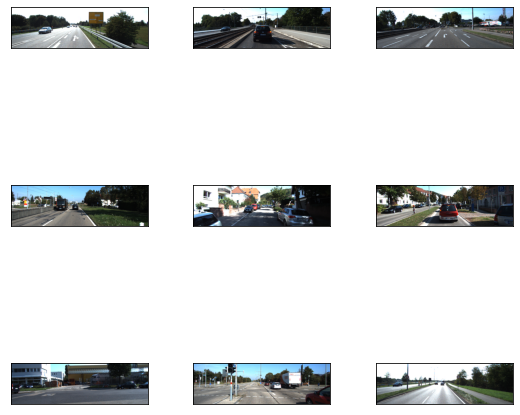

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'b

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.61], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.42954665, 0.5828664 , 0.50509334, 0.60881644]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.43, 1.55, 3.91]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 7.04,  2.15, 39.44]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.43], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


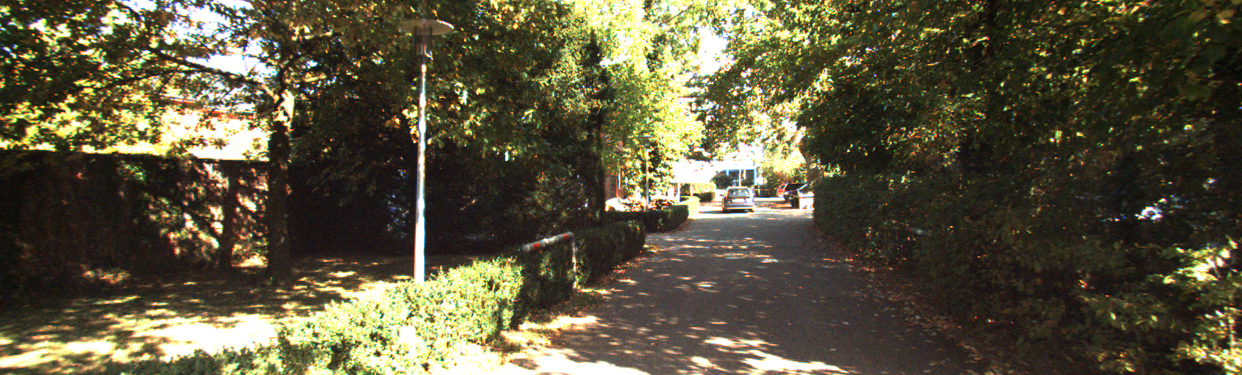

In [5]:
TakeDataset = ds_train.take(1)

for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(1, 4)
[723.92004 213.92    756.15    185.59   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FAF2C6D1E50>


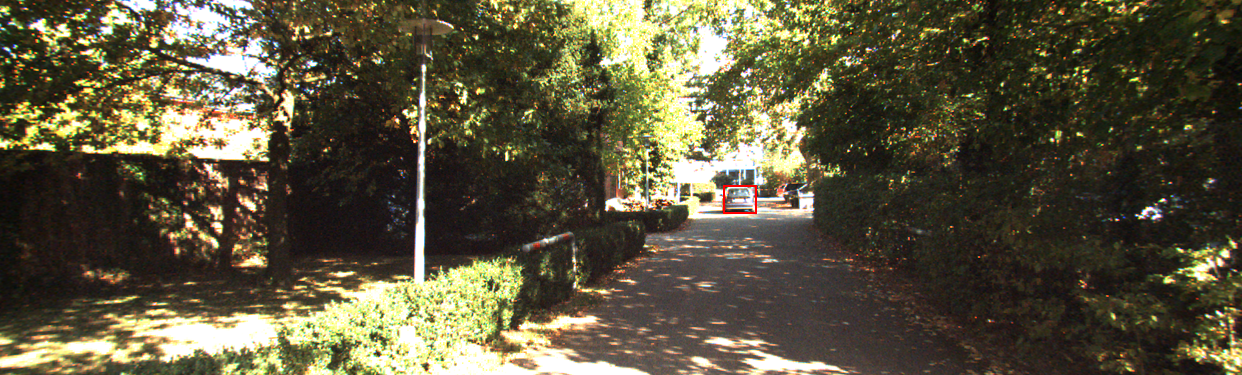

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 1. Keras-retinanet

### 클래스 및 바운딩 박스 정보 추출

In [7]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [20:25<00:00,  5.18it/s]


- tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었다.
- 이를 활용하여 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 생성한다.

In [8]:
# 테스트 데이터셋에도 동일 과정 적용
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [02:27<00:00,  4.81it/s]


### 클래스 맵핑

In [9]:
class_txt_path = data_dir + '/classes.txt'

# 각 클래스를 숫자 인덱스에 맵핑
def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

### 학습하기

In [10]:
# RetinaNet 훈련 시작!
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-10-18 13:38:45.192773: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-18 13:38:45.192826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-18 13:38:46.715809: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-18 13:38:46.724860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.92GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-18 13:38:46.725010: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 3.4543 - regression_loss: 2.6201 - classification_loss: 0.8342
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 1359s 7s/step - loss: 3.4543 - regression_loss: 2.6201 - classification_loss: 0.8342
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 2.7354 - regression_loss: 2.1891 - classification_loss: 0.5463
Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
195/195 [==============================] - 1359s 7s/step - loss: 2.7354 - regression_loss: 2.1891 - classification_loss: 0.5463
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 2.2417 - regression_loss: 1.7939 - classification_loss: 0.4478
Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
195/195 [==============================] - 1359s 7s/step - loss: 2.2417 - regression_loss: 1.7939 - classification_loss: 0.4478
Epoch 4/10
195/195 [=================

In [11]:
# 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5

2021-10-18 17:27:00.300067: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-18 17:27:00.300118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-18 17:27:01.793336: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-18 17:27:01.801643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.92GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-18 17:27:01.801784: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

### 시각화

In [12]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import cv2
import time

gpu = '0'
setup_gpu(gpu)

work_dir = os.getenv('HOME')+'/aiffel/object_detection'
model_path = os.path.join(work_dir, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

In [13]:
def inference_on_image(model, img_path="./test_set/go_0.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:  # 일정 점수 이하는 제외
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

## 2. 자율주행 보조 시스템 만들기
- 입력으로 이미지 경로를 받습니다.
- 다음 정지조건에 맞는 경우 "Stop", 아닌 경우 "Go"를 반환합니다.
  - 사람이 한 명 이상 있는 경우
  - 차량의 크기(width or height)가 300px이상인 경우

In [16]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.4:  # 일정 점수 이하는 제외
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
            
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result

## 3. 자율주행 보조 시스템 평가하기
- 이미지 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가한다.

[777.8105  153.63585 845.35803 318.4505 ]


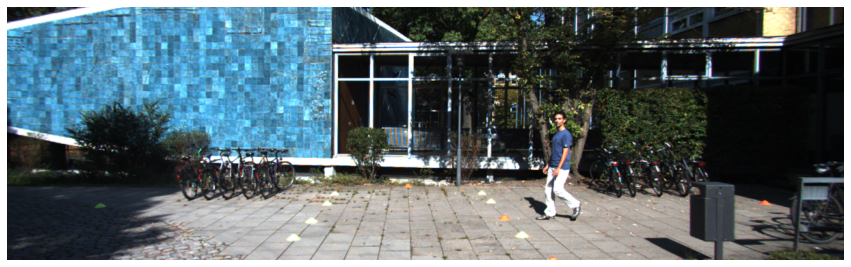

test_set/stop_1.png
prediction: Go, answer: Stop

[419.6568  166.08507 501.53607 336.1978 ]


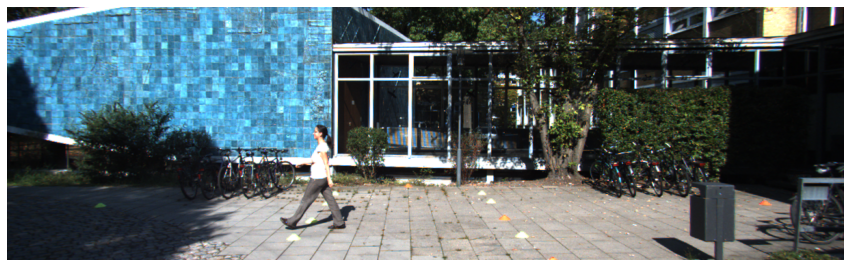

test_set/stop_2.png
prediction: Go, answer: Stop

[ 27.85827 195.75967 289.83832 369.12827]
[760.10754 159.94083 883.92413 208.28473]


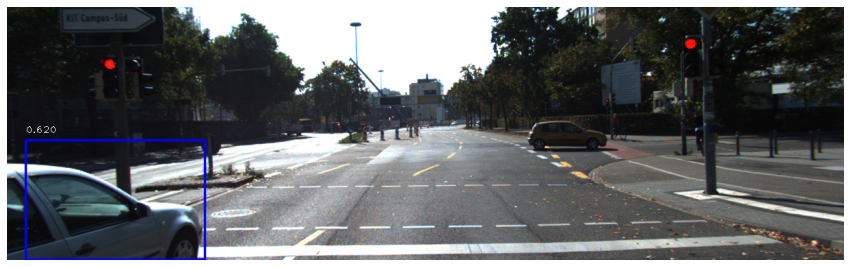

test_set/stop_3.png
prediction: Go, answer: Stop

[114.28495 152.19414 362.3949  308.6471 ]


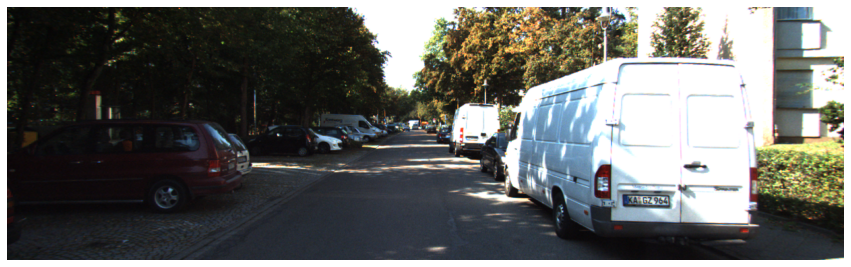

test_set/stop_4.png
prediction: Go, answer: Stop

[ 880.82196  170.87598 1175.7296   364.20868]


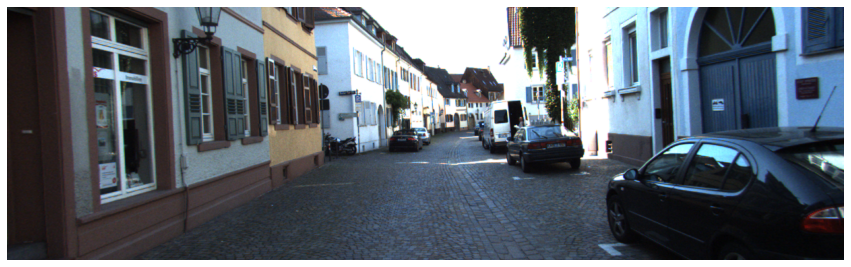

test_set/stop_5.png
prediction: Go, answer: Stop

[590.1878  171.35085 623.19055 204.15378]
[188.51845 133.69092 355.78732 232.99437]


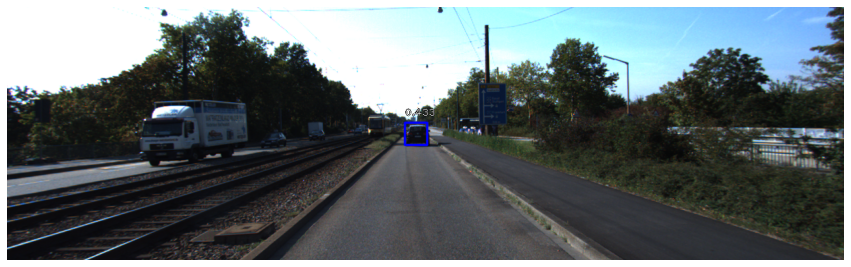

test_set/go_1.png
prediction: Go, answer: Go

[624.36426 174.97975 665.49286 213.19084]
[611.4463  172.47043 681.16376 220.03175]


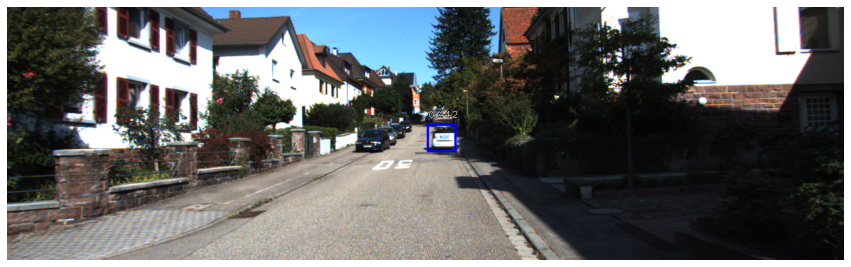

test_set/go_2.png
prediction: Go, answer: Go

[807.8725  145.15256 880.2185  175.37604]


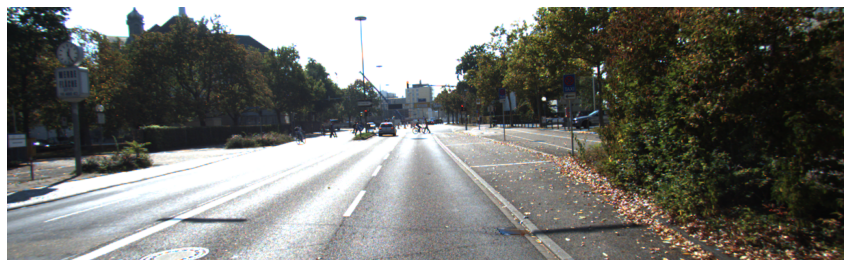

test_set/go_3.png
prediction: Go, answer: Go

[694.65015 164.65201 789.19885 248.11693]


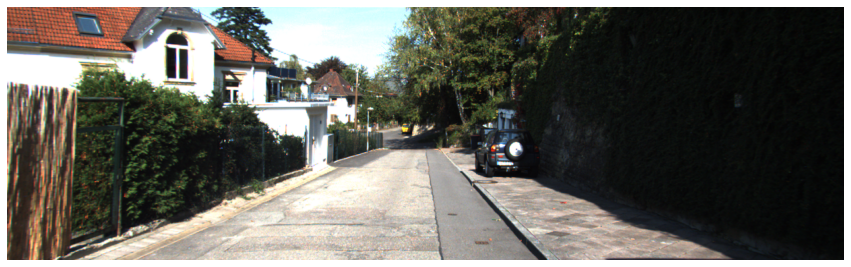

test_set/go_4.png
prediction: Go, answer: Go

[  4.579069 186.22255  218.70442  306.62805 ]


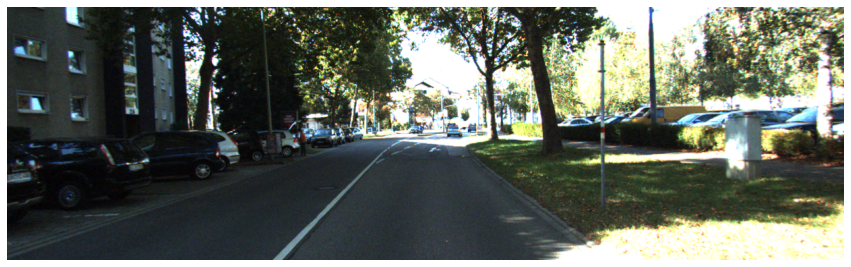

test_set/go_5.png
prediction: Go, answer: Go

결과: 50점입니다.


In [17]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(model=model, img_path=image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        if pred == answer:
            score += 10
    print(f"결과: {score}점입니다.")
    
test_system(self_drive_assist)

# 프로젝트 결과
- 학습하는데 시간이 생각보다 너무 많이 걸려서 시간관계상 10에폭으로 테스트를 했는데 역시나 Object Detection 능력이 떨어지는게 보였다.
- 기본값이 Go이기 때문에 디텍션을 못하면 Go가 나와서 50점이 그나마 나온것이고 차량이나 사람을 인식하는 능력이 부족한게 보인다.
- 시간과 좋은 컴퓨터가 있다면 꼭 50에폭으로 테스트 해보고 싶다.